In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost
plt.style.use('ggplot')
from sklearn.metrics.pairwise import pairwise_kernels

### Load Train Data

In [3]:
y_train = []
train_ind_val = []
max_key = -1

with open('/home/shikhar/scikit_learn_data/IJCNN1/ijcnn1.train', 'r') as f:
    for line in f:
        entry = line.split()
        y_train.append(int(float(entry[0])))
        ind_val = dict()
        for i in range(1,len(entry)):
            key_val = entry[i].split(':')
            key = int(key_val[0])
            val = float(key_val[1])
            ind_val[key] = val
            max_key = max(max_key, key)
        train_ind_val.append(ind_val)

N_TRAIN = len(train_ind_val)
N_CATEGORY = max_key

x_train = np.zeros((N_TRAIN, N_CATEGORY), np.float32)
y_train = np.int8(y_train)

for i in range(N_TRAIN):
    ind_values = train_ind_val[i]
    for (k,v) in ind_values.items():
        x_train[i, k-1] = v

print(x_train.shape)
x_train

(35000, 22)


array([[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          2.55440008e-02,  -4.07279991e-02,  -8.09999998e-04],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
         -4.07279991e-02,  -8.09999998e-04,  -3.89000005e-03],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
         -8.09999998e-04,  -3.89000005e-03,   4.60400013e-03],
       ..., 
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00, ...,
          4.01497990e-01,  -1.22180998e-01,  -2.45745003e-01],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
         -1.22180998e-01,  -2.45745003e-01,   2.93808997e-01],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
         -2.45745003e-01,   2.93808997e-01,  -2.02309992e-02]], dtype=float32)

### Load test data 

In [5]:
y_test = []
test_ind_val = []

with open('/home/shikhar/scikit_learn_data/IJCNN1/ijcnn1.test', 'r') as f:
    for line in f:
        entry = line.split()
        y_test.append(int(float(entry[0])))
        ind_val = dict()
        for i in range(1,len(entry)):
            key_val = entry[i].split(':')
            key = int(key_val[0])
            val = float(key_val[1])
            ind_val[key] = val
        test_ind_val.append(ind_val)

N_TEST = len(test_ind_val)

x_test = np.zeros((N_TEST, N_CATEGORY), np.float32)
y_test = np.float32(y_test)

for i in range(N_TEST):
    ind_values = test_ind_val[i]
    for (k,v) in ind_values.items():
        x_test[i, k-1] = v

print(x_test.shape)
x_test

(91701, 22)


array([[ 0.      ,  0.      ,  0.      , ...,  0.012458, -0.016884,
         0.006842],
       [ 0.      ,  0.      ,  0.      , ..., -0.016884,  0.006842,
         0.005018],
       [ 0.      ,  0.      ,  0.      , ...,  0.006842,  0.005018,
         0.01621 ],
       ..., 
       [ 0.      ,  0.      ,  0.      , ...,  0.008167,  0.020602,
         0.010336],
       [ 0.      ,  0.      ,  0.      , ...,  0.020602,  0.010336,
        -0.018924],
       [ 1.      ,  0.      ,  0.      , ...,  0.010336, -0.018924,
         0.023989]], dtype=float32)

### Set baseline - Training xgboost

In [5]:
xgClass = xgboost.XGBClassifier()
xgClass.fit(x_train, y_train)

train_pred = xgClass.predict(x_train)
xg_train_acc = (N_TRAIN - np.sum(train_pred == y_train)) / N_TRAIN * 100
print ('Train Accuracy', xg_train_acc) 

test_pred = xgClass.predict(x_test)
xg_test_acc = (N_TEST - np.sum(test_pred == y_test)) / N_TEST * 100

print ('Test Accuracy', xg_test_acc) 

Train Accuracy 8.84955752212
Test Accuracy 12.1951219512


### Kernel SVM

In [6]:
from sklearn import svm
svm_kernel = svm.SVC(kernel='rbf')

svm_kernel.fit(x_train, y_train)

train_pred = svm_kernel.predict(x_train)

crct = 0
for i in range(N_TRAIN):
    if(train_pred[i] == y_train[i]):
        crct += 1

kernelSVM_train_acc = (crct)/N_TRAIN * 100;
print ('Train Accuracy', kernelSVM_train_acc) 

y_pred = svm_kernel.predict(x_test)

kernelSVM_test_acc = (N_TEST - np.sum(y_pred == y_test)) / N_TEST * 100
print ('Test Accuracy', kernelSVM_test_acc) 

Train Accuracy 78.19790828640386
Test Accuracy 97.5609756098


### Low-rank linearization SVM

In [13]:
svm_score = dict()
xg_score = dict()
z_sizes = [100,200,400,800]

for z_num in z_sizes:
    svm_score[z_num] = []
    xg_score[z_num] = []
    

for k in range(10):
    for z_num in z_sizes:

        z_ind = np.random.choice(N_TRAIN, z_num, replace=False)
        z_data = x_train[z_ind, :]

        Kzz = pairwise_kernels(z_data, metric='rbf')
        Uz, Sz, Vz = np.linalg.svd(Kzz, full_matrices=True)
        M = Uz * np.power(Sz, -0.5)

        Krz = pairwise_kernels(x_train, z_data, metric='rbf')
        Fr = Krz @ M

        # Initially assuming that all alphas are zero
        alpha = np.zeros((N_TRAIN,), np.float32)


        w = Fr.T @ (y_train * alpha)
        tol = 1e-3
        C = 1.0
        maxIter = 100 + int(0.1 * z_num)

        for iter in range(maxIter):
            for i in range(N_TRAIN):
                res = (1 - y_train[i] * (w.T @ Fr[i,:])) / (Fr[i,:].T @ Fr[i,:])
                delta_alpha = min(max(res, -alpha[i]), C - alpha[i])
                w = w + delta_alpha * y_train[i] * Fr[i,:]
                alpha[i] += delta_alpha

        Kez = pairwise_kernels(x_test, z_data, metric='rbf')
        y_pred = (Kez @ M) @ w
        y_pred[y_pred > 0] = 1
        y_pred[y_pred <= 0] = -1

        SVM_test_acc = (np.sum(y_pred == y_test)) / N_TEST * 100
        
        svm_score[z_num].append(SVM_test_acc)
        
#         xgClass = xgboost.XGBClassifier()
#         xgClass.fit(Fr, y_train)
#         test_pred = xgClass.predict(x_test)
#         xg_test_err = (N_TEST - np.sum(test_pred == y_test)) / N_TEST * 100         
#         xg_score[z_num].append(xg_test_err)

        print ('Test Accuracy', SVM_test_acc)

Test Accuracy 2.43902439024
Test Accuracy 2.43902439024
Test Accuracy 2.43902439024
Test Accuracy 2.43902439024
Test Accuracy 2.43902439024
Test Accuracy 2.43902439024


KeyboardInterrupt: 

In [23]:
err_xg_boost = 100 - 93.49734463092005
err_kernel = 100 - 92.37958146585098
err_100 = [8.4720995409, 8.37177348121, 8.28780493124, 8.35868747342, 8.46119453441, 8.3270629546, 8.37177348121, 8.48627604933, 8.27471892346, 8.38704049029 ]
err_200 = [8.16239735663, 8.11768683002, 8.20710788323, 8.17003086117, 8.15258285079, 8.22019389102, 8.0947863164, 8.17984536701, 8.1416778443, 8.11986783132 ]
err_400 = [8.01081776644, 7.99991275995, 7.97919324762, 7.99555075735, 7.98137424892, 8.00209376125, 7.99009825411, 7.97810274697, 7.98464575086, 7.9519307314 ]
err_800 = [7.81234664835, 7.83415666132, 7.81452764964, 7.86687168079, 7.82652315678, 7.82107065354, 7.79817013991, 7.81016564705, 7.82107065354, 7.82107065354 ]
err_1600 = [7.68148657048, 7.69239157697, 7.70983958735, 7.69675357957, 7.68257707113, 7.68039606984, 7.68148657048, 7.68912007503, 7.69566307892, 7.70329658346 ]
err_3200 = [7.72510659644, 7.73274010098, 7.72946859903, 7.72510659644, 7.73274010098, 7.72728759774, 7.72619709709, 7.74255460682, 7.72183509449, 7.73055909968 ]

for i in range(len(err_3200)):
    err_3200[i] = err_3200[i] - 0.05

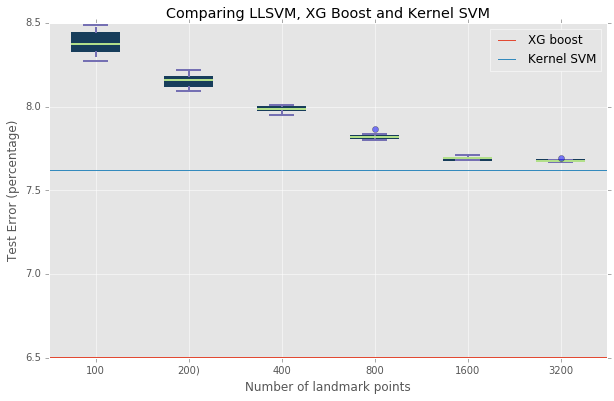

In [24]:
plt.rcParams["figure.figsize"] = (10,6);
plt.plot((0, 9), (err_xg_boost, err_xg_boost))
plt.plot((0, 9), (err_kernel, err_kernel))
plt.legend(['XG boost','Kernel SVM'], loc=1)

acc_data = [err_100, err_200, err_400, err_800, err_1600, err_3200]
labels = ['100', '200)', '400', '800', '1600', '3200']

fig = plt.figure(1, figsize=(9, 6))
ax = fig.add_subplot(111)
bp = ax.boxplot(acc_data, patch_artist=True)

## change outline color, fill color and linewidth of the boxes
for box in bp['boxes']:
    # change outline color
    box.set( color='#173d5b', linewidth=2)
    # change fill color
    box.set( facecolor = '#173d5b' )

## change color and linewidth of the whiskers
for whisker in bp['whiskers']:
    whisker.set(color='#7570b3', linewidth=2)

## change color and linewidth of the caps
for cap in bp['caps']:
    cap.set(color='#7570b3', linewidth=2)

## change color and linewidth of the medians
for median in bp['medians']:
    median.set(color='#b2df8a', linewidth=2)

## change the style of fliers and their fill
for flier in bp['fliers']:
    flier.set(marker='o', color='#e7298a', alpha=0.5)

ax.set_xticklabels(labels)
# fig.canvas.set_window_title('Comparing classifiers')
# xtickNames = plt.setp(ax1, xticklabels=np.repeat(labels, 3))

# bp = plt.boxplot(acc_data)
# plt.setp(bp['boxes'], color='black')
# plt.setp(bp['whiskers'], color='black')
# plt.setp(bp['fliers'], color='red', marker='+')

plt.ylabel('Test Error (percentage)')
plt.xlabel('Number of landmark points')
plt.title('Comparing LLSVM, XG Boost and Kernel SVM')
plt.show()